# Пример применения автоэнкодера для решения задачи реконструкции изображений для датасета MNIST
Выполнил: Ландызин А.Н. М092101(71)
<hr>

 * **Автоэнкодер** 
 : тип искусственной нейронной сети, используемой для обучения эффективному кодированию данных неконтролируемым образом
 
 Основные структурные части автоэнкодера:
 * **Энкодер g** : преобразует входной сигнал в его представление (код) | $h = g(x)$
 * **Декодер f** : преообразует код в выходные данные | $x = f(h) $

В общем смысле автоэнкодер изменяя f и g стремится выучить тождественную функцию $x = f(g(x))$ минимизируя ошибку.

 * **Потенциал применения** : 
1. Снижение размерности 
2. Минимизация шума
3. Детектирование аномалий



<hr>

<a id="one"></a>

# 1.Импорты

In [1]:
from google.colab import drive
import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

<hr>

<a id="two"></a>

# 2. Подготовка датасета.
Используется набор данных MNIST Fashion 

https://www.kaggle.com/zalando-research/fashionmnist

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Чтение датасета
# train_x = изображения вещей
# train_y = маркировка вещей
train = pd.read_csv("/content/drive/MyDrive/ITIB/Autoencoder_demo/data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

In [4]:
train_x[:1] 

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,   0,
          0,   0,   0,  62,  61,  21,  29,  23,  51, 136,  61,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  88, 201, 228, 225, 255, 115,  62, 137, 255, 235, 222,
        255, 135,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  47, 252, 234, 238, 224, 215, 215, 229, 108, 180, 207,
        214, 224, 231, 249, 254,  45,   0,   0,   0,   0,   0,   0,   0,
          0,   1,   0,   0, 214, 222, 210, 213, 224

In [5]:
train_y[:5]

array([2, 9, 6, 0, 3])

In [6]:

# нормализуем набор данных train_x в промежуток 0..1
train_x = train_x / 255

# разделим датасет на тренировочные данные(80%) и валидирующие(20%) 
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

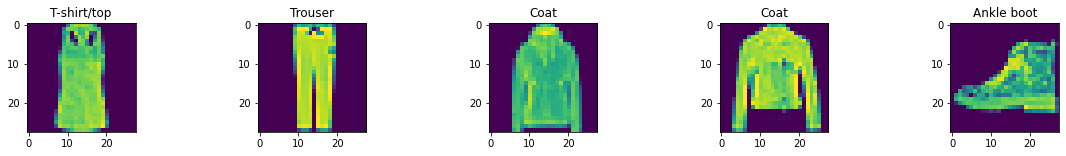

In [7]:
#Наглядно выведем составляющие датасета
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
x_train = np.array(train_x).reshape(-1, 28, 28) / 255.0
fig, ax = plt.subplots(1, 5, figsize=(20, 2))
for i in range(5):
    ax[i].imshow(x_train[i], cmap='viridis')
    ax[i].set_title(labeldict[train_y[i]])

In [8]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [9]:
train_x[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00784314, 0.        , 0.        ,
       0.41568627, 0.78431373, 0.85882353, 0.81568627, 0.85882353,
       0.83137255, 0.78431373, 0.50980392, 0.        , 0.        ,
       0.00392157, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01176471, 0.        , 0.44705882, 0.80784314, 0.78431373,
       0.75686275, 0.66666667, 0.70196078, 0.75294118, 0.8       ,
       0.7372549 , 0.65490196, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02352941, 0.        ,
       0.58431373, 0.63137255, 0.01960784, 0.90588235, 0.63529412,
       0.65490196, 0.89019608, 0.29019608, 0.21176471, 0.8    



# 3. Моделирование нейросети (вход ~ выход)


In [18]:
## Входной слой
input_layer = Input(shape=(784,))

## Слои кодировки
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## Слой представления
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## Слои декодировки
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## Выходной слой
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_16 (Dense)            (None, 1500)              1177500   
                                                                 
 dense_17 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_18 (Dense)            (None, 500)               500500    
                                                                 
 dense_19 (Dense)            (None, 10)                5010      
                                                                 
 dense_20 (Dense)            (None, 500)               5500      
                                                                 
 dense_21 (Dense)            (None, 1000)              5010

<a id="four"></a>

# 4. Тренировка нейросети

In [ ]:
#earlystopping - фича tf для остановки обучения если параметр прекратил изменяться в процессе обучения
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=15, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

In [19]:
model.compile(optimizer='adam', loss='mse')
model.fit(train_x, train_x, epochs=15, batch_size=2048, validation_data=(val_x, val_x))

Epoch 1/15
24/24 [==============================] - 34s 1s/step - loss: 0.0977 - val_loss: 0.0715
Epoch 2/15
24/24 [==============================] - 33s 1s/step - loss: 0.0653 - val_loss: 0.0577
Epoch 3/15
24/24 [==============================] - 33s 1s/step - loss: 0.0509 - val_loss: 0.0441
Epoch 4/15
24/24 [==============================] - 33s 1s/step - loss: 0.0407 - val_loss: 0.0384
Epoch 5/15
24/24 [==============================] - 33s 1s/step - loss: 0.0366 - val_loss: 0.0351
Epoch 6/15
24/24 [==============================] - 33s 1s/step - loss: 0.0332 - val_loss: 0.0316
Epoch 7/15
24/24 [==============================] - 33s 1s/step - loss: 0.0303 - val_loss: 0.0285
Epoch 8/15
24/24 [==============================] - 33s 1s/step - loss: 0.0277 - val_loss: 0.0263
Epoch 9/15
24/24 [==============================] - 33s 1s/step - loss: 0.0256 - val_loss: 0.0250
Epoch 10/15
24/24 [==============================] - 33s 1s/step - loss: 0.0246 - val_loss: 0.0240
Epoch 11/15
24/24 [

In [20]:
preds = model.predict(val_x)

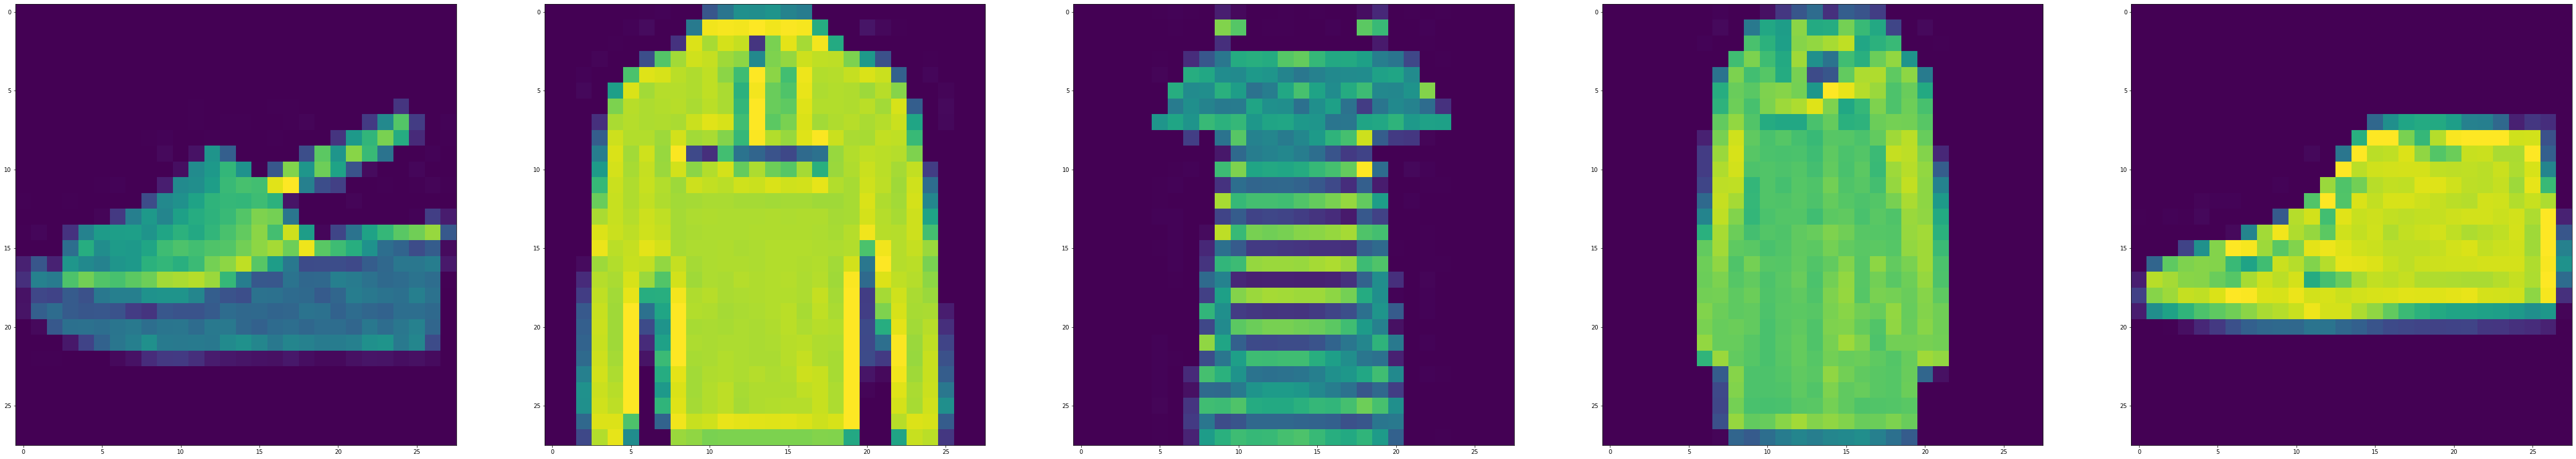

In [21]:
#Изначальные картинки val_x
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

<a id="five"></a>

# 5. Результат работы

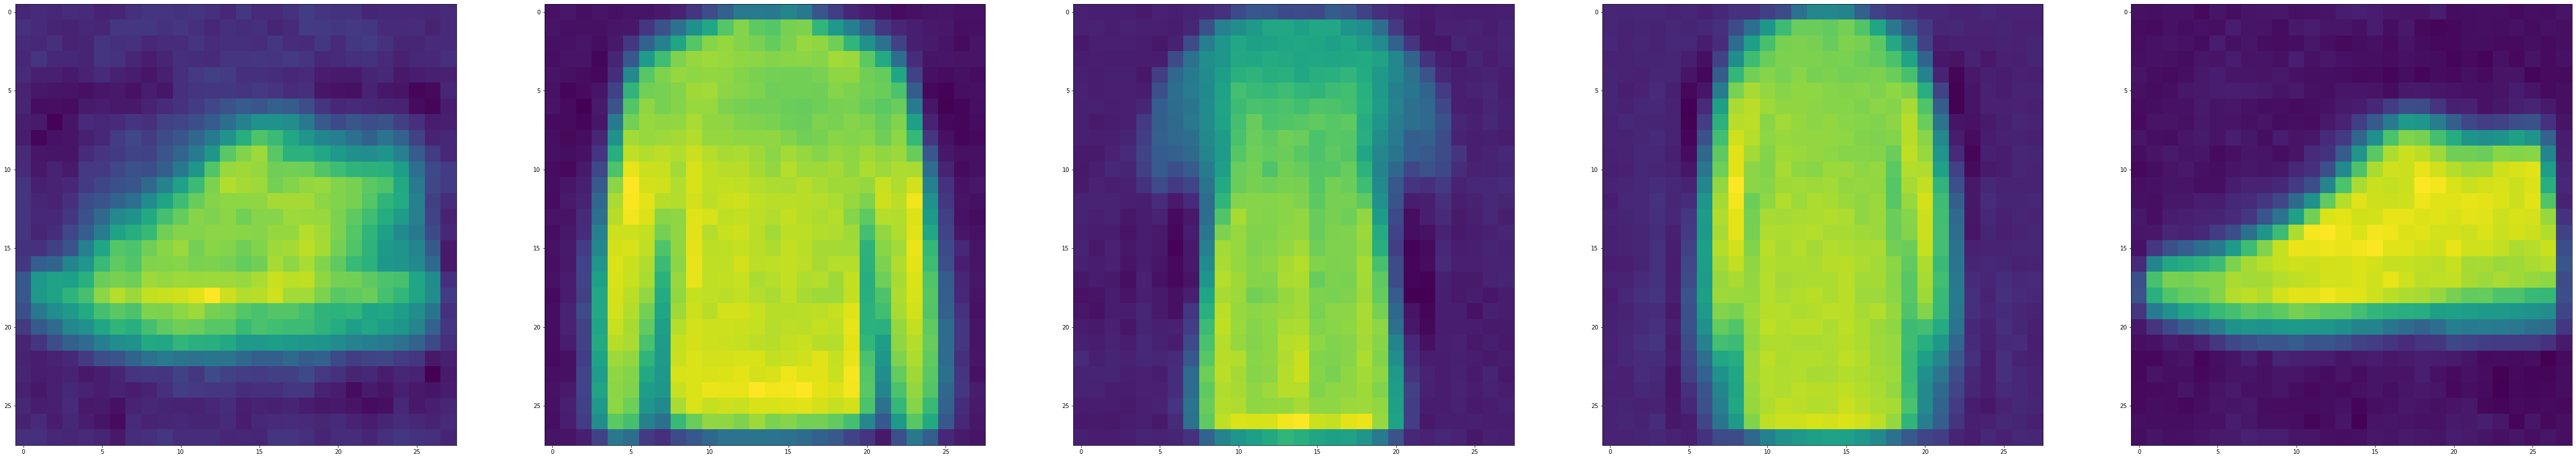

In [22]:
#Картинки после автоэнкодера preds
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()